In [101]:
# Standard library imports
import warnings
from pathlib import Path
import joblib

# Third-party imports
import pandas as pd

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

import analysis
from settings import config
from pull_taq import get_taq_nbbo, get_taq_wct
from transform_taq import extract_features_taq
from strategy import (
    create_labels,
    train_ml_model_pipeline,
    signal_to_returns
)

In [3]:
# Change default pandas display options

pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 200
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.expand_frame_repr', False)

# Global variables
RAW_DATA_DIR = Path(config("RAW_DATA_DIR"))
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR = Path(config("OUTPUT_DIR"))
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR = Path(config("PROCESSED_DATA_DIR"))
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
WRDS_USERNAME = config("WRDS_USERNAME")

## 1. Load TAQ data

### 1.1. Quotes Data

Pull quotes data from TAQ database (NBBO)
- Display first 5 rows to confirm data is loaded correctly

In [4]:
quotes = get_taq_nbbo(('NVDA'), date='2024-03-07', use_bars=False)
display(quotes.head())

,ticker,date,time_m,best_bid,best_bidsizeshares,best_ask,best_asksizeshares,time_quote
0,NVDA,2024-03-07,0 days 09:30:00.001931,901.2500,700,901.6900,500,2024-03-07 09:30:00.001931030-05:00
1,NVDA,2024-03-07,0 days 09:30:00.032887,901.8500,300,901.6900,500,2024-03-07 09:30:00.032887301-05:00
2,NVDA,2024-03-07,0 days 09:30:00.033894,901.8500,200,901.6900,500,2024-03-07 09:30:00.033894108-05:00
3,NVDA,2024-03-07,0 days 09:30:00.033897,901.8500,100,901.6900,500,2024-03-07 09:30:00.033897303-05:00
4,NVDA,2024-03-07,0 days 09:30:00.033992,901.4500,100,901.6900,500,2024-03-07 09:30:00.033992528-05:00


### 1.2. Trades Data

Pull quotes data from Trades database (WCT)
- Display first 5 rows to confirm data is loaded correctly

In [5]:
trades = get_taq_wct(('NVDA'), date='2024-03-07')
display(trades.head())

,ticker,date,time_trade,price,size
0,NVDA,2024-03-07,2024-03-07 09:30:00.001652-05:00,901.5400,13
1,NVDA,2024-03-07,2024-03-07 09:30:00.001929-05:00,901.6100,25
2,NVDA,2024-03-07,2024-03-07 09:30:00.001929-05:00,901.6300,10
3,NVDA,2024-03-07,2024-03-07 09:30:00.001934-05:00,901.6600,46
4,NVDA,2024-03-07,2024-03-07 09:30:00.002086-05:00,901.5100,4


---
---
## 2. Data Preparation & Feature Engineering

#### 2.1. Merge Quotes and Trades

Asof-join of quotes and trades dataframes
- Match each trade with the most recent quote, keeping only rows with actual trades (left join) (that naturally discards pure-quote timestamps that lack trades.)
- Display first 5 rows to confirm data is loaded correctly

In [6]:
# Asof-join on trade_ts (left side) to quote_ts (right side).
merged_trades = pd.merge_asof(
    trades.sort_values("time_trade"),
    quotes.sort_values("time_quote")[["time_quote", "best_bid", "best_bidsizeshares", "best_ask", "best_asksizeshares"]],
    left_on="time_trade",
    right_on="time_quote",
    direction="backward"  # Ensures we take the most recent quote before the trade
)
merged_trades = merged_trades.drop(columns="time_quote")
display(merged_trades.head())

# Save the merged trades to cache
merged_trades.to_csv(PROCESSED_DATA_DIR / "merged_trades.csv", index=False)


,ticker,date,time_trade,price,size,best_bid,best_bidsizeshares,best_ask,best_asksizeshares
0,NVDA,2024-03-07,2024-03-07 09:30:00.001652-05:00,901.5400,13,<NA>,<NA>,<NA>,<NA>
1,NVDA,2024-03-07,2024-03-07 09:30:00.001929-05:00,901.6100,25,<NA>,<NA>,<NA>,<NA>
2,NVDA,2024-03-07,2024-03-07 09:30:00.001929-05:00,901.6300,10,<NA>,<NA>,<NA>,<NA>
3,NVDA,2024-03-07,2024-03-07 09:30:00.001934-05:00,901.6600,46,901.2500,700,901.6900,500
4,NVDA,2024-03-07,2024-03-07 09:30:00.002086-05:00,901.5100,4,901.2500,700,901.6900,500



### 2.2. Feature Engineering

---
#### **Duration since last trade**:
- Time since the last trade.

---
#### **Mid price**:
- Average of the best bid and ask prices.
$$MP = \frac{\text{best bid price} + \text{best ask price}}{2}$$

---
#### **EWMA Price Returns**:
- To mitigate tick sensitivity, we can compute returns using an exponentially weighted moving average (EWMA) of past prices.
$$
r_t^{(T)} = \log \left( \frac{P_t}{\text{EWMA} \left(P, \lambda = \frac{1}{T} \right)} \right)
$$
- This smooths out price fluctuations and provides a more stable return measure.


---
#### **Order-weighted average price**:
- Weighted average of the best bid and ask prices.
$$
OWA = \frac{\sqrt{\text{ask size}}}{\sqrt{\text{ask size} + \text{bid size}}} \times \text{best bid price} + \frac{\sqrt{\text{bid size}}}{\sqrt{\text{ask size} + \text{bid size}}} \times \text{best ask price}
$$

---
#### **Spread**:
- Difference between the best ask and bid prices.
$$\text{Spread} = \text{best ask price} - \text{best bid price}$$

---
#### **Rolling Spread Mean, Coefficient of Variation & Z-score**:
- Instead of just using the instantaneous spread, we track its mean, coefficient of variation and z-score over a given rolling time period.
$$
\text{Spread Mean}_t = \frac{1}{T} \sum_{i=t-T}^{t} \text{Spread}_i
$$
$$
\text{Spread CV}_t = \frac{\text{Spread Std}_t}{\text{Spread Mean}_t}
$$
$$
\text{Spread Z-score}_t = \frac{\text{Spread}_t - \text{Spread Mean}_t}{\text{Spread Std}_t}
$$

$$\frac{\text{Spread Std}_t} = \sqrt{\frac{1}{T} \sum_{i=t-T}^{t} (\text{Spread}_i - \text{Spread Mean}_t)^2}$$

- This helps detect **spread widening** events, spread instability (CV) and liquidity shocks.

---
#### **Trade direction (sign)**:
- we mark trades with +1 for buyer-initiated, -1 for seller-initiated.
    - Find the best bid and offer as of the trade time
    - Compare the trade price to them
    - If the trade price equals the best bid, mark as seller-initiated
    - If the trade price equals the best offer, mark as buyer-initiated
    - Otherwise, mark according to whether trade price was below or above mid price

---
#### **Size imbalance**:
- A common intuition among traders is that the order sizes displayed at the top of the book reflect the general intention of the market. When the number of shares at the bid exceeds that at the ask, participants  expect the next price movement to be upwards, and vice versa. 

$$\text{SI} = \frac{\text{ask size} - \text{bid size}}{\text{ask size} + \text{bid size}}$$

---
#### **Order imbalance**:
- The order imbalance is the absolute difference between the volume of buyer-initiated and seller-initiated trades, divided by their sum over a _fixed volume bucket_.
- This metric is designed to measure market stress, not directional bias, which is why we take the absolute value—positive and negative imbalances would cancel each other out, potentially understating the overall level of informed trading.

$$\text{I}_n = \frac{\left| V_n^B - V_n^S \right|}{V_n^B + V_n^S}$$

(_where $V_n^B$ and $V_n^S$ are the volume of buyer-initiated and seller-initiated trades in the _n-th fixed volume bucket_, respectively._)

---
#### **Volume-weighted probability of informed trading (VPIN)**:
- The rolling average of Order Imbalance over the last _$N$ volume buckets_.

$$VPIN = \frac{1}{N} \sum_{n=1}^{N} I_n$$

where each $OI_n$ corresponds to the order imbalance calculated for a fixed-volume bucket, ensuring that VPIN reflects market activity in a volume-synchronized manner rather than fixed time or trade intervals.

---
#### **Trade Flow**:
- An extension of the VPIN, a running tally of signed trade sizes where the sign is defined as 1 if the trade was seller-initiated and -1 if it was buyer-initiated.
- At any moment, we examine all reported trades within the last time period of length $\tau$.
- The essential idea behind flow as a quantitative metric is that, in circumstances when many sellers are willing to cross that market-making bid-offer spread to complete their transactions, there is likely to be new information driving their choices. We do not know exactly what it is, but we certainly want to adapt to it.

- When flow has a stable sign over macroscopic periods of time, it is a manifestation of supply and demand imbalance, and so it (usually) corresponds to steady price movements over a given time period.

$$F_t^{(\tau)} = V_{(t-\tau, t)}^B - V_{(t-\tau, t)}^S$$

---
#### **Order Flow Imbalance (OFI)**:
- A measure of excess buying or selling pressure at the top of the order book, it represents the changes in supply and demand at the best bid and ask prices.
$$
\text{OFI} = (\text{Best Bid Size}_{t} - \text{Best Bid Size}_{t-1}) - (\text{Best Ask Size}_{t} - \text{Best Ask Size}_{t-1})
$$
- Best bid or size at the best bid increase -> increase in demand.
- Best bid or size at the best bid decreases -> decrease in demand.
- Best ask decreases or size at the best ask increases -> increase in supply.
- Best ask increases or size at the best ask decreases -> decrease in supply.

---
#### **Market Pressure (MP)**:
- Captures the aggressiveness of market orders relative to available liquidity.
- Higher values indicate stronger directional pressure.
$$
\text{MP}_t = \frac{\text{Trade Volume}_t}{\text{Bid Size}_t + \text{Ask Size}_t}


In [62]:
feats_df = extract_features_taq(merged_trades.iloc[3:],
                            half_life_s=60,
                            spread_window="60s",
                            flow_time_step="100ms",
                            flow_window="5s",
                            bucket_size=1000,
                            vpin_buckets=30,
                            vwap_past_window="60s",
                            vwap_future_window="20s")
print(feats_df.tail(10))

                              time_trade  best_bid  best_ask    price  mid_price  owa_price  ewma_price_return  ewma_mid_price_return  ewma_owa_price_return  past_vwap  future_vwap  trade_sign  duration_since_last_trade  size_imbalance  market_pressure   OFI  trade_flow  spread_mean  spread_CV  spread_Zscore
1102070 2024-03-07 15:59:59.909980-05:00  925.9400  926.9300 926.9200   926.4350   926.4350             0.0005                 0.0000                 0.0000   926.6056     926.4787           1                     0.0000          0.0000           0.0325     0 -30369.0000       0.1950     0.9703         4.2017
1102071 2024-03-07 15:59:59.910684-05:00  925.9400  926.9300 926.7900   926.4350   926.4350             0.0004                 0.0000                 0.0000   926.6056     926.4646           1                     0.0007          0.0000           0.2175     0 -30369.0000       0.1951     0.9707         4.1977
1102072 2024-03-07 15:59:59.911426-05:00  925.9400  926.9300 926.2500 

In [9]:
print(feats_df.isnull().sum())  # Count NaNs in each column

time_trade                   0
best_bid                     0
best_ask                     0
price                        0
mid_price                    0
owa_price                    0
ewma_price_return            0
ewma_mid_price_return        0
ewma_owa_price_return        0
past_vwap                    0
future_vwap                  0
trade_sign                   0
duration_since_last_trade    1
size_imbalance               0
market_pressure              0
OFI                          1
trade_flow                   0
spread_mean                  0
spread_CV                    1
spread_Zscore                1
dtype: int64


In [10]:
feats_df = feats_df.dropna()

# Create prices df for strategy simulation
best_price_df = feats_df.set_index('time_trade')[['best_bid', 'best_ask']]

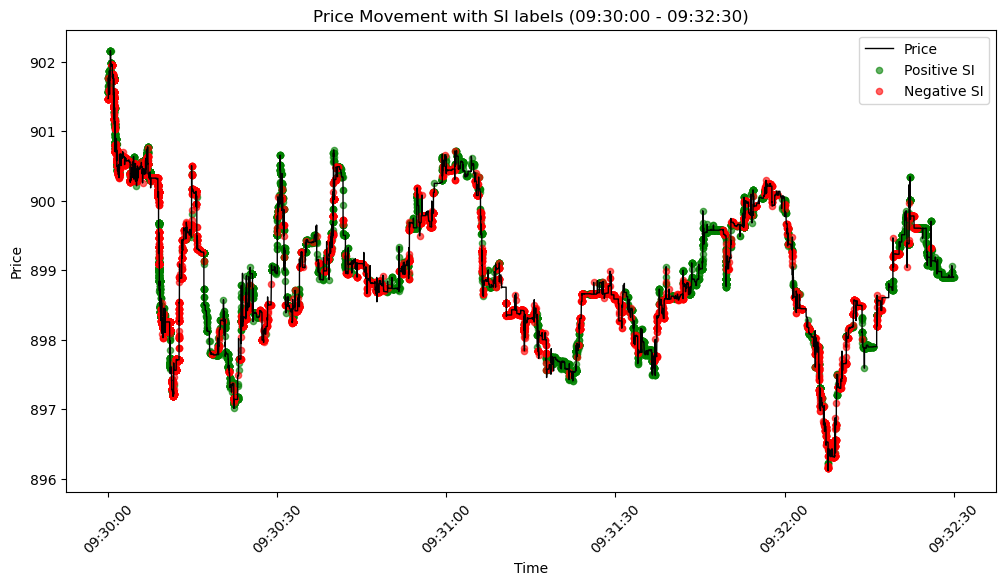

Correlation between SI and price change: 0.1137
P-value: 0.0000e+00
The correlation is statistically significant.
Percentage of time SI and significant price change had same signs: 68.54%


In [102]:
analysis.analysis(feats_df, 2.5, 1, 0.0005)

---
---
## 3. Machine Learning Model for Trade Signal Prediction

**Overview**

This section outlines the end-to-end pipeline for building a machine learning model to predict trade signals based on market microstructure features. The objective is to classify each time step into one of three categories:  
- **Buy signal (+1)** → Indicates a likely upward price movement.  
- **Hold signal (0)** → No action recommended.  
- **Sell signal (-1)** → Indicates a likely downward price movement.  

We achieve this through feature engineering, time-series cross-validation, model training, and performance evaluation.

---

#### 3.1. Future Return Calculation & Signal Labeling
To train a classification model, we first compute the **future return** based on the future VWAP and the current price. This helps us create a label for supervised learning.

**Steps:**

1. _Compute the log future return:_
   \[
   \text{future\_return}_t = \log\left(\frac{\text{future\_VWAP}_t}{\text{price}_t}\right)
   \]
2. _Classify each time step into buy/hold/sell:_
   - A **buy signal (+1)** is assigned if the future return exceeds **mean + std deviation**.
   - A **sell signal (-1)** is assigned if the future return is below **mean - std deviation**.
   - Otherwise, a **hold signal (0)** is assigned.

    _Note: there is some look-ahead bias in this approach, since we are using all data to calculate the mean and standard deviation, but we will acception that for this exercise_.

3. _Remove any missing values** to ensure consistency in modeling._

---

#### 3.2. Machine Learning Model Training
We use a **Random Forest Classifier** with hyperparameter tuning to predict future price movements.

**Preprocessing & Feature Scaling**
- _Feature Scaling_: Certain features (e.g., `trade_sign`, `spread_Zscore`) do not require scaling, while others benefit from StandardScaler.
- _Dimensionality Reduction (Optional):_ If needed, _PCA_ is applied to reduce redundant information.

**Time-Series Cross-Validation**
Unlike traditional cross-validation, time-series data requires __forward-looking validation_:
- We use _TimeSeriesSplit_ to progressively expand the training set.
- The test set always consists of future unseen data.

**Hyperparameter Optimization**
- We use _RandomizedSearchCV_ to find the best hyperparameters for:
  - `max_depth`
  - `min_samples_split`
  - `n_estimators`
- The best model is selected based on _**_cross-validation accuracy_.

**Model Evaluation**
- Performance is measured using _Accuracy_ and _F1-score_ on both training and test sets.
- A final holdout test set ensures realistic performance assessment.
- The trained model is saved for future predictions.

---

### 3.3. Trade Execution & Strategy Return Calculation
Once the model generates trade signals, we must determine the **actual execution price** and compute **strategy returns**.

**Trade Execution Rules**
- If _signal = +1_, we _buy_ at the next _best ask price_ (after a 1ms delay).
- If _signal = -1_, we _sell_ at the next _best bid price_.
- If _signal changes from +1 to -1**, a _full reversal_ occurs, meaning we sell the current position and take a new short position.
- If _signal changes from -1 to +1_, we close the short position and enter a long.

**Trade Size Scaling**
Each trade is adjusted based on _up_weight_ and _down_weight_:
- `up_weight` scales the size of long trades.
- `down_weight` scales the size of short trades.
- If moving from neutral to long, the trade size is `+up_weight`.
- If moving from neutral to short, the trade size is `-down_weight`.
- If flipping long to short, the total trade size is `-(up_weight + down_weight)`.
- If flipping short to long, the total trade size is `+(up_weight + down_weight)`.

**Strategy Return Calculation**
- The trade price is determined at execution (`ask` for buys, `bid` for sells).
- We consider a total transaction cost of 0.01% of price for each trade.
- The _strategy return_ is computed as:
  $$
  \text{strategy\_return}_t = \text{trade\_size}_{t-1} \times \frac{\text{executed\_price}_t}{\text{executed\_price}_{t-1}} - 1
  $$
- Returns are _cumulative_ over time, forming the basis of strategy performance evaluation.


This methodology provides a scalable approach for predicting market movements and evaluating systematic trading strategies.


In [ ]:
# Create future return & classification labels
LABEL_COL="ml_signal"

feats_df = create_labels(
    feats_df,
    price_col="price",
    future_vwap_col="future_vwap",
    out_return_col="future_return",
    out_label_col=LABEL_COL,
    buy_threshold_std=1.0,
    sell_threshold_std=1.0,
)

# Select relevant features
feats_df = feats_df[[
        "ewma_mid_price_return",
        "trade_sign",
        "duration_since_last_trade",
        "size_imbalance",
        "market_pressure",
        "OFI",
        "trade_flow",
        "spread_mean",
        "spread_CV",
        "spread_Zscore"
    ]]

print(feats_df.tail())

**Observations:**
- There are only 4 missing values, so we will remove them.

In [ ]:
# Check if model already exists:
MODEL_NAME = "random_forest_hft_signal"
model_path = f"{OUTPUT_DIR}/models/{MODEL_NAME}.pkl"
if Path(model_path).exists():
    print(f"Model already exists at {model_path}")
    ml_model = joblib.load(model_path)

else:    
    # Train the ML pipeline
    ml_model = train_ml_model_pipeline(
        data=feats_df,
        label_col=LABEL_COL,
        use_pca=True,
        pca_components = 0.90,
        train_size=0.8,
        model_name="random_forest_hft_signal",
        model_path = f"{OUTPUT_DIR}/models/"
    )

In [ ]:
# Generate signals from the model:
features_only = feats_df.drop(columns=[LABEL_COL], errors="ignore")
signals = ml_model.predict(feats_df.dropna())


In [ ]:
# Convert signals to actual strategy returns using next ask price:
signals_df = pd.DataFrame(signals, index=best_price_df.index, columns=["signals"])
STRATEGY_NAME = "ML_strategy"
strategy_ret = signal_to_returns(
    signals=signals_df, 
    best_prices=best_price_df, 
    strategy_name=STRATEGY_NAME, 
    lookahead_timedelta=pd.Timedelta("1ms")
)

# Evaluate strategy performance
cum_ret = (1.0 + strategy_ret[f"{STRATEGY_NAME}_returns"]).cumprod() - 1.0
print("Final strategy return = ", cum_ret.iloc[-1])